0.9542696742851415
Snapshot 0: Central Count = 9449, Satellite Count = 0
1.2057071479210513
Snapshot 1: Central Count = 13885, Satellite Count = 1323
1.5775475632516653
Snapshot 2: Central Count = 17942, Satellite Count = 2706
1.8555198186075816
Snapshot 3: Central Count = 19203, Satellite Count = 3527
2.196877475830365
Snapshot 4: Central Count = 19961, Satellite Count = 4129
2.3731673349414217
Snapshot 5: Central Count = 20154, Satellite Count = 4203
2.545319685838771
Snapshot 6: Central Count = 20254, Satellite Count = 4265
2.729540916603993
Snapshot 7: Central Count = 20263, Satellite Count = 4368
2.926582617964171
Snapshot 8: Central Count = 20257, Satellite Count = 4496
3.137222302955239
Snapshot 9: Central Count = 20137, Satellite Count = 4567
3.362259562496793
Snapshot 10: Central Count = 20017, Satellite Count = 4639
3.602511025118021
Snapshot 11: Central Count = 19834, Satellite Count = 4674
3.8588039678616846
Snapshot 12: Central Count = 19631, Satellite Count = 4847
4.13196

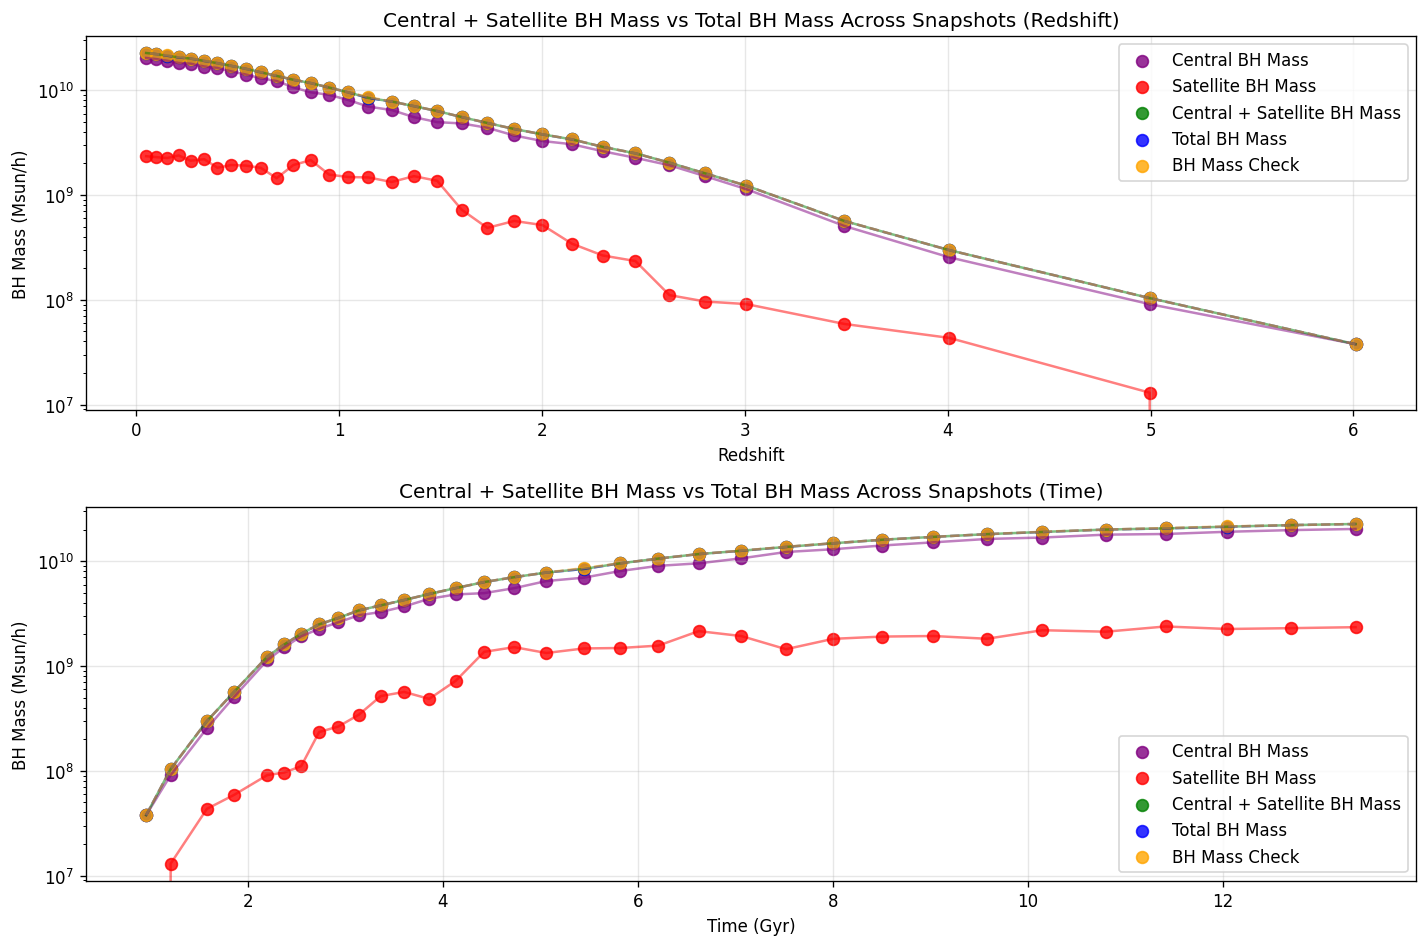

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# Constants
h = 0.6711

snapshot_base_path = "data/Output-fidTNG_CAMELS/snap_"
catalog_base_path = "data/Output-fidTNG_CAMELS/fof_subhalo_tab_"
snapshot_indices = range(0, 34)

# Function to convert redshift to time since Big Bang
def time_since_big_bang(redshift):
    redshift_conversion = FlatLambdaCDM(H0=67.11, Om0=0.3, Ob0=0.045)
    time = redshift_conversion.age(redshift).value
    return time
    
# Initialize result lists
snapshot_ids = []
redshifts = []
scale_factors = []
times = []

total_bh_masses = []
central_bh_masses = []
satellite_bh_masses = []
bh_mass_check = []

for snap_idx in snapshot_indices:
    f_catalog = f"{catalog_base_path}{snap_idx:03d}.hdf5"
    snapshotData = f"{snapshot_base_path}{snap_idx:03d}.hdf5"
    try:
        with h5py.File(f_catalog, 'r') as f, h5py.File(snapshotData, 'r') as data:
            # Load all necessary data at once
            group_first_sub = f['Group/GroupFirstSub'][:].astype("int32")
            group_bh_masses = f['Group/GroupBHMass'][:] * 1e10  #Msun/h
            subhalo_bh_masses = f['Subhalo/SubhaloBHMass'][:] * 1e10  #Msun/h
            subhalo_group_nr = f['Subhalo/SubhaloGroupNr'][:].astype("int32")
            bh_masses = data['PartType5/BH_Mass'][:] * 1e10
            
            redshift = f['Header'].attrs['Redshift']
            
            # Convert redshift to time since the Big Bang
            time = time_since_big_bang(redshift)

            # Precompute central BH masses
            valid_central_idx = group_first_sub[group_first_sub >= 0]
            
            central_bh_masses_per_group = subhalo_bh_masses[valid_central_idx] 
            central_mass_sum = central_bh_masses_per_group.sum()       

            satellite_mass_sum = subhalo_bh_masses.sum() - central_mass_sum 
            
            # Count satellites efficiently
            _, satellite_counts = np.unique(subhalo_group_nr, return_counts=True)
            satellite_count = satellite_counts.sum() - len(valid_central_idx)  # Exclude central

        print(time)
        # Store results
        snapshot_ids.append(snap_idx)
        redshifts.append(redshift)
        scale_factors.append(scale_factor)
        times.append(time)
        
        total_bh_masses.append(np.sum(subhalo_bh_masses))
        central_bh_masses.append(central_mass_sum)
        satellite_bh_masses.append(satellite_mass_sum)
        bh_mass_check.append(np.sum(bh_masses))

        # Debug counts
        print(f"Snapshot {snap_idx}: Central Count = {len(valid_central_idx)}, Satellite Count = {satellite_count}")
        
    except FileNotFoundError:
        print(f"File {f_catalog} not found. Skipping.")
    except KeyError as e:
        print(f"Key error {e} in snapshot {snap_idx}. Skipping.")
        
# Convert results to arrays
total_mass_central = np.array(central_bh_masses)  # Total central BH mass
total_mass_satellite = np.array(satellite_bh_masses)  # Total satellite BH mass
total_mass_all = np.array(total_bh_masses)  # Total BH mass (central + satellite)

# Plotting
plt.figure(figsize=(12, 8), dpi=120)

# Plot for Redshift
plt.subplot(2, 1, 1)  # First plot (Redshift)
plt.scatter(redshifts, total_mass_central, color='purple', s=50, alpha=0.8, label="Central BH Mass")
plt.plot(redshifts, total_mass_central, color='purple', linestyle='-', alpha=0.5)

plt.scatter(redshifts, total_mass_satellite, color='red', s=50, alpha=0.8, label="Satellite BH Mass")
plt.plot(redshifts, total_mass_satellite, color='red', linestyle='-', alpha=0.5)

plt.scatter(redshifts, total_mass_central + total_mass_satellite, color='green', s=50, alpha=0.8, label="Central + Satellite BH Mass")
plt.plot(redshifts, total_mass_central + total_mass_satellite, color='green', linestyle='-', alpha=0.5)

plt.scatter(redshifts, total_mass_all, color='blue', s=50, alpha=0.8, label="Total BH Mass")
plt.plot(redshifts, total_mass_all, color='blue', linestyle='--', alpha=0.5)

plt.scatter(redshifts, bh_mass_check, color='orange', s=50, alpha=0.8, label="BH Mass Check")
plt.plot(redshifts, bh_mass_check, color='orange', linestyle='--', alpha=0.5)

plt.xlabel("Redshift")
plt.ylabel("BH Mass (Msun/h)")
plt.yscale("log")
plt.title("Central + Satellite BH Mass vs Total BH Mass Across Snapshots (Redshift)")
plt.grid(alpha=0.3)
plt.legend()

# Plot for Time (Time since Big Bang)
plt.subplot(2, 1, 2) 
plt.scatter(times, total_mass_central, color='purple', s=50, alpha=0.8, label="Central BH Mass")
plt.plot(times, total_mass_central, color='purple', linestyle='-', alpha=0.5)

plt.scatter(times, total_mass_satellite, color='red', s=50, alpha=0.8, label="Satellite BH Mass")
plt.plot(times, total_mass_satellite, color='red', linestyle='-', alpha=0.5)

plt.scatter(times, total_mass_central + total_mass_satellite, color='green', s=50, alpha=0.8, label="Central + Satellite BH Mass")
plt.plot(times, total_mass_central + total_mass_satellite, color='green', linestyle='-', alpha=0.5)

plt.scatter(times, total_mass_all, color='blue', s=50, alpha=0.8, label="Total BH Mass")
plt.plot(times, total_mass_all, color='blue', linestyle='--', alpha=0.5)

plt.scatter(times, bh_mass_check, color='orange', s=50, alpha=0.8, label="BH Mass Check")
plt.plot(times, bh_mass_check, color='orange', linestyle='--', alpha=0.5)

plt.xlabel("Time (Gyr)")
plt.ylabel("BH Mass (Msun/h)")
plt.yscale("log")
plt.title("Central + Satellite BH Mass vs Total BH Mass Across Snapshots (Time)")
plt.grid(alpha=0.3)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

#redshift 6 = about 1 gigayear to check 